In [71]:
#hide
#!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [72]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

Having seen what it looks like to actually train a variety of models in Chapter 2, let’s now look under the hood and see exactly what is going on. We’ll start by using computer vision to introduce fundamental tools and concepts for deep learning.

To be exact, we'll discuss the roles of arrays and tensors and of broadcasting, a powerful technique for using them expressively. We'll explain stochastic gradient descent (SGD), the mechanism for learning by updating weights automatically. We'll discuss the choice of a loss function for our basic classification task, and the role of mini-batches. We'll also describe the math that a basic neural network is actually doing. Finally, we'll put all these pieces together.

In future chapters we’ll do deep dives into other applications as well, and see how these concepts and tools generalize. But this chapter is about laying foundation stones. To be frank, that also makes this one of the hardest chapters, because of how these concepts all depend on each other. Like an arch, all the stones need to be in place for the structure to stay up. Also like an arch, once that happens, it's a powerful structure that can support other things. But it requires some patience to assemble.

Let's begin. The first step is to consider how images are represented in a computer.

## Pixels: The Foundations of Computer Vision

In order to understand what happens in a computer vision model, we first have to understand how computers handle images. We'll use one of the most famous datasets in computer vision, [MNIST](https://en.wikipedia.org/wiki/MNIST_database), for our experiments. MNIST contains images of handwritten digits, collected by the National Institute of Standards and Technology and collated into a machine learning dataset by Yann Lecun and his colleagues. Lecun used MNIST in 1998 in [Lenet-5](http://yann.lecun.com/exdb/lenet/), the first computer system to demonstrate practically useful recognition of handwritten digit sequences. This was one of the most important breakthroughs in the history of AI.

## Sidebar: Tenacity and Deep Learning

The story of deep learning is one of tenacity and grit by a handful of dedicated researchers. After early hopes (and hype!) neural networks went out of favor in the 1990's and 2000's, and just a handful of researchers kept trying to make them work well. Three of them, Yann Lecun, Yoshua Bengio, and Geoffrey Hinton, were awarded the highest honor in computer science, the Turing Award (generally considered the "Nobel Prize of computer science"), in 2018 after triumphing despite the deep skepticism and disinterest of the wider machine learning and statistics community.

Geoff Hinton has told of how even academic papers showing dramatically better results than anything previously published would be rejected by top journals and conferences, just because they used a neural network. Yann Lecun's work on convolutional neural networks, which we will study in the next section, showed that these models could read handwritten text—something that had never been achieved before. However, his breakthrough was ignored by most researchers, even as it was used commercially to read 10% of the checks in the US!

In addition to these three Turing Award winners, there are many other researchers who have battled to get us to where we are today. For instance, Jurgen Schmidhuber (who many believe should have shared in the Turing Award) pioneered many important ideas, including working with his student Sepp Hochreiter on the long short-term memory (LSTM) architecture (widely used for speech recognition and other text modeling tasks, and used in the IMDb example in <<chapter_intro>>). Perhaps most important of all, Paul Werbos in 1974 invented back-propagation for neural networks, the technique shown in this chapter and used universally for training neural networks ([Werbos 1994](https://books.google.com/books/about/The_Roots_of_Backpropagation.html?id=WdR3OOM2gBwC)). His development was almost entirely ignored for decades, but today it is considered the most important foundation of modern AI.

There is a lesson here for all of us! On your deep learning journey you will face many obstacles, both technical, and (even more difficult) posed by people around you who don't believe you'll be successful. There's one *guaranteed* way to fail, and that's to stop trying. We've seen that the only consistent trait amongst every fast.ai student that's gone on to be a world-class practitioner is that they are all very tenacious.

## End sidebar

For this initial tutorial we are just going to try to create a model that can classify any image as a 3 or a 7. So let's download a sample of MNIST that contains images of just these digits:

In [64]:
URLs.MNIST_SAMPLE??

In [66]:
untar_data??

In [7]:
path = untar_data(URLs.MNIST_SAMPLE)

In [10]:
#hide
Path.BASE_PATH = path

We can see what's in this directory by using `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more. One of its handy features is that, when printed, it displays the count of items, before listing the items themselves (if there are more than 10 items, it just shows the first few):

In [12]:
path.ls?

In [13]:
path.ls??

In [74]:
doc(path.ls)

In [69]:
URLs?

In [15]:
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Let's see what's inside the training set:

In [16]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the *labels* (or targets) in this dataset. Let's take a look in one of these folders (using `sorted` to ensure we all get the same order of files):

In [22]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

As we might expect, it's full of image files. Let’s take a look at one now. Here’s an image of a handwritten number 3, taken from the famous MNIST dataset of handwritten numbers:

In [23]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

Here we are using the `Image` class from the *Python Imaging Library* (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a *NumPy array* or a *PyTorch tensor*. For instance, here's what a section of the image looks like, converted to a NumPy array:

In [24]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

The `4:10` indicates we requested the rows from index 4 (included) to 10 (not included) and the same for the columns. NumPy indexes from top to bottom and left to right, so this section is located in the top-left corner of the image. Here's the same thing as a PyTorch tensor:

In [25]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

We can slice the array to pick just the part with the top of the digit in it, and then use a Pandas DataFrame to color-code the values using a gradient, which shows us clearly how the image is created from the pixel values:

In [26]:
#hide_output
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


You can see that the background white pixels are stored as the number 0, black is the number 255, and shades of gray are between the two. The entire image contains 28 pixels across and 28 pixels down, for a total of 784 pixels. (This is much smaller than an image that you would get from a phone camera, which has millions of pixels, but is a convenient size for our initial learning and experiments. We will build up to bigger, full-color images soon.)

So, now you've seen what an image looks like to a computer, let's recall our goal: create a model that can recognize 3s and 7s. How might you go about getting a computer to do that?

> Warning: Stop and Think!: Before you read on, take a moment to think about how a computer might be able to recognize these two different digits. What kinds of features might it be able to look at? How might it be able to identify these features? How could it combine them together? Learning works best when you try to solve problems yourself, rather than just reading somebody else's answers; so step away from this book for a few minutes, grab a piece of paper and pen, and jot some ideas down…

## First Try: Pixel Similarity

So, here is a first idea: how about we find the average pixel value for every pixel of the 3s, then do the same for the 7s. This will give us two group averages, defining what we might call the "ideal" 3 and 7. Then, to classify an image as one digit or the other, we see which of these two ideal digits the image is most similar to. This certainly seems like it should be better than nothing, so it will make a good baseline.

> jargon: Baseline: A simple model which you are confident should perform reasonably well. It should be very simple to implement, and very easy to test, so that you can then test each of your improved ideas, and make sure they are always better than your baseline. Without starting with a sensible baseline, it is very difficult to know whether your super-fancy models are actually any good. One good approach to creating a baseline is doing what we have done here: think of a simple, easy-to-implement model. Another good approach is to search around to find other people that have solved similar problems to yours, and download and run their code on your dataset. Ideally, try both of these!

Step one for our simple model is to get the average of pixel values for each of our two groups. In the process of doing this, we will learn a lot of neat Python numeric programming tricks!

Let's create a tensor containing all of our 3s stacked together. We already know how to create a tensor containing a single image. To create a tensor containing all the images in a directory, we will first use a Python list comprehension to create a plain list of the single image tensors.

We will use Jupyter to do some little checks of our work along the way—in this case, making sure that the number of returned items seems reasonable:

In [28]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

> note: List Comprehensions: List and dictionary comprehensions are a wonderful feature of Python. Many Python programmers use them every day, including the authors of this book—they are part of "idiomatic Python." But programmers coming from other languages may have never seen them before. There are a lot of great tutorials just a web search away, so we won't spend a long time discussing them now. Here is a quick explanation and example to get you started. A list comprehension looks like this: `new_list = [f(o) for o in a_list if o>0]`. This will return every element of `a_list` that is greater than 0, after passing it to the function `f`. There are three parts here: the collection you are iterating over (`a_list`), an optional filter (`if o>0`), and something to do to each element (`f(o)`). It's not only shorter to write but way faster than the alternative ways of creating the same list with a loop.

We'll also check that one of the images looks okay. Since we now have tensors (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's `show_image` function to display it:

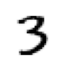

In [29]:
show_image(three_tensors[1]);

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a *rank-3 tensor*. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called `stack` that we can use for this purpose.

Some operations in PyTorch, such as taking a mean, require us to *cast* our integer types to float types. Since we'll be needing this later, we'll also cast our stacked tensor to `float` now. Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

In [30]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

Perhaps the most important attribute of a tensor is its *shape*. This tells you the length of each axis. In this case, we can see that we have 6,131 images, each of size 28×28 pixels. There is nothing specifically about this tensor that says that the first axis is the number of images, the second is the height, and the third is the width—the semantics of a tensor are entirely up to us, and how we construct it. As far as PyTorch is concerned, it is just a bunch of numbers in memory.

The *length* of a tensor's shape is its rank:

In [31]:
len(stacked_threes.shape)

3

It is really important for you to commit to memory and practice these bits of tensor jargon: _rank_ is the number of axes or dimensions in a tensor; _shape_ is the size of each axis of a tensor.

> A: Watch out because the term "dimension" is sometimes used in two ways. Consider that we live in "three-dimensonal space" where a physical position can be described by a 3-vector `v`. But according to PyTorch, the attribute `v.ndim` (which sure looks like the "number of dimensions" of `v`) equals one, not three! Why? Because `v` is a vector, which is a tensor of rank one, meaning that it has only one _axis_ (even if that axis has a length of three). In other words, sometimes dimension is used for the size of an axis ("space is three-dimensional"); other times, it is used for the rank, or the number of axes ("a matrix has two dimensions"). When confused, I find it helpful to translate all statements into terms of rank, axis, and length, which are unambiguous terms.

We can also get a tensor's rank directly with `ndim`:

In [ ]:
stacked_threes.ndim

3

Finally, we can compute what the ideal 3 looks like. We calculate the mean of all the image tensors by taking the mean along dimension 0 of our stacked, rank-3 tensor. This is the dimension that indexes over all the images.

In other words, for every pixel position, this will compute the average of that pixel over all images. The result will be one value for every pixel position, or a single image. Here it is:

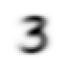

In [34]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

According to this dataset, this is the ideal number 3! (You may not like it, but this is what peak number 3 performance looks like.) You can see how it's very dark where all the images agree it should be dark, but it becomes wispy and blurry where the images disagree. 

Let's do the same thing for the 7s, but put all the steps together at once to save some time:

In [36]:
stacked_sevens.mean()

tensor(0.1145)

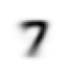

In [40]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

Let's now pick an arbitrary 3 and measure its *distance* from our "ideal digits."

> stop: Stop and Think!: How would you calculate how similar a particular image is to each of our ideal digits? Remember to step away from this book and jot down some ideas before you move on! Research shows that recall and understanding improves dramatically when you are engaged with the learning process by solving problems, experimenting, and trying new ideas yourself

Here's a sample 3:

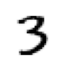

In [32]:
a_3 = stacked_threes[1]
show_image(a_3);

How can we determine its distance from our ideal 3? We can't just add up the differences between the pixels of this image and the ideal digit. Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal. That would be misleading!

To avoid this, there are two main ways data scientists measure distance in this context:

- Take the mean of the *absolute value* of differences (absolute value is the function that replaces negative values with positive values). This is called the *mean absolute difference* or *L1 norm*
- Take the mean of the *square* of differences (which makes everything positive) and then take the *square root* (which undoes the squaring). This is called the *root mean squared error* (RMSE) or *L2 norm*.

> important: It's Okay to Have Forgotten Your Math: In this book we generally assume that you have completed high school math, and remember at least some of it... But everybody forgets some things! It all depends on what you happen to have had reason to practice in the meantime. Perhaps you have forgotten what a _square root_ is, or exactly how they work. No problem! Any time you come across a maths concept that is not explained fully in this book, don't just keep moving on; instead, stop and look it up. Make sure you understand the basic idea, how it works, and why we might be using it. One of the best places to refresh your understanding is Khan Academy. For instance, Khan Academy has a great [introduction to square roots](https://www.khanacademy.org/math/algebra/x2f8bb11595b61c86:rational-exponents-radicals/x2f8bb11595b61c86:radicals/v/understanding-square-roots).

Let's try both of these now:

In [38]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [41]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

PyTorch already provides both of these as *loss functions*. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai):

In [42]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Here `mse` stands for *mean squared error*, and `l1` refers to the standard mathematical jargon for *mean absolute value* (in math it's called the *L1 norm*).

> S: Intuitively, the difference between L1 norm and mean squared error (MSE) is that the latter will penalize bigger mistakes more heavily than the former (and be more lenient with small mistakes).

> J: When I first came across this "L1" thingie, I looked it up to see what on earth it meant. I found on Google that it is a _vector norm_ using _absolute value_, so looked up _vector norm_ and started reading: _Given a vector space V over a field F of the real or complex numbers, a norm on V is a nonnegative-valued any function p: V → \[0,+∞) with the following properties: For all a ∈ F and all u, v ∈ V, p(u + v) ≤ p(u) + p(v)..._ Then I stopped reading. "Ugh, I'll never understand math!" I thought, for the thousandth time. Since then I've learned that every time these complex mathy bits of jargon come up in practice, it turns out I can replace them with a tiny bit of code! Like, the _L1 loss_ is just equal to `(a-b).abs().mean()`, where `a` and `b` are tensors. I guess mathy folks just think differently than me... I'll make sure in this book that every time some mathy jargon comes up, I'll give you the little bit of code it's equal to as well, and explain in common-sense terms what's going on.

We just completed various mathematical operations on PyTorch tensors. If you've done some numeric programming in NumPy before, you may recognize these as being similar to NumPy arrays. Let's have a look at those two very important data structures.

### NumPy Arrays and PyTorch Tensors

[NumPy](https://numpy.org/) is the most widely used library for scientific and numeric programming in Python. It provides very similar functionality and a very similar API to that provided by PyTorch; however, it does not support using the GPU or calculating gradients, which are both critical for deep learning. Therefore, in this book we will generally use PyTorch tensors instead of NumPy arrays, where possible.

(Note that fastai adds some features to NumPy and PyTorch to make them a bit more similar to each other. If any code in this book doesn't work on your computer, it's possible that you forgot to include a line like this at the start of your notebook: `from fastai.vision.all import *`.)

But what are arrays and tensors, and why should you care?

Python is slow compared to many languages. Anything fast in Python, NumPy, or PyTorch is likely to be a wrapper for a compiled object written (and optimized) in another language—specifically C. In fact, **NumPy arrays and PyTorch tensors can finish computations many thousands of times faster than using pure Python.**

A NumPy array is a multidimensional table of data, with all items of the same type. Since that can be any type at all, they can even be arrays of arrays, with the innermost arrays potentially being different sizes—this is called a "jagged array." By "multidimensional table" we mean, for instance, a list (dimension of one), a table or matrix (dimension of two), a "table of tables" or "cube" (dimension of three), and so forth. If the items are all of some simple type such as integer or float, then NumPy will store them as a compact C data structure in memory. This is where NumPy shines. NumPy has a wide variety of operators and methods that can run computations on these compact structures at the same speed as optimized C, because they are written in optimized C.

A PyTorch tensor is nearly the same thing as a NumPy array, but with an additional restriction that unlocks some additional capabilities. It's the same in that it, too, is a multidimensional table of data, with all items of the same type. However, the restriction is that a tensor cannot use just any old type—it has to use a single basic numeric type for all components. For example, a PyTorch tensor cannot be jagged. It is always a regularly shaped multidimensional rectangular structure.

The vast majority of methods and operators supported by NumPy on these structures are also supported by PyTorch, but PyTorch tensors have additional capabilities. One major capability is that these structures can live on the GPU, in which case their computation will be optimized for the GPU and can run much faster (given lots of values to work on). In addition, PyTorch can automatically calculate derivatives of these operations, including combinations of operations. As you'll see, it would be impossible to do deep learning in practice without this capability.

> S: If you don't know what C is, don't worry as you won't need it at all. In a nutshell, it's a low-level  (low-level means more similar to the language that computers use internally) language that is very fast compared to Python. To take advantage of its speed while programming in Python, try to avoid as much as possible writing loops, and replace them by commands that work directly on arrays or tensors.

Perhaps the most important new coding skill for a Python programmer to learn is how to effectively use the array/tensor APIs. We will be showing lots more tricks later in this book, but here's a summary of the key things you need to know for now.

To create an array or tensor, pass a list (or list of lists, or list of lists of lists, etc.) to `array()` or `tensor()`:

In [43]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [44]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [45]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

All the operations that follow are shown on tensors, but the syntax and results for NumPy arrays is identical.

You can select a row (note that, like lists in Python, tensors are 0-indexed so 1 refers to the second row/column):

In [ ]:
tns[1]

tensor([4, 5, 6])

or a column, by using `:` to indicate *all of the first axis* (we sometimes refer to the dimensions of tensors/arrays as *axes*):

In [50]:
tns[:,1]

tensor([2, 5])

You can combine these with Python slice syntax (`[start:end]` with `end` being excluded) to select part of a row or column:

In [51]:
tns[1,1:3]

tensor([5, 6])

And you can use the standard operators such as `+`, `-`, `*`, `/`:

In [52]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

Tensors have a type:

In [53]:
tns.type()

'torch.LongTensor'

And will automatically change type as needed, for example from `int` to `float`:

In [54]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

So, is our baseline model any good? To quantify this, we must define a metric.

## Computing Metrics Using Broadcasting

Recall that a metric is a number that is calculated based on the predictions of our model, and the correct labels in our dataset, in order to tell us how good our model is. For instance, we could use either of the functions we saw in the previous section, mean squared error, or mean absolute error, and take the average of them over the whole dataset. However, neither of these are numbers that are very understandable to most people; in practice, we normally use *accuracy* as the metric for classification models.

As we've discussed, we want to calculate our metric over a *validation set*. This is so that we don't inadvertently overfit—that is, train a model to work well only on our training data. This is not really a risk with the pixel similarity model we're using here as a first try, since it has no trained components, but we'll use a validation set anyway to follow normal practices and to be ready for our second try later.

To get a validation set we need to remove some of the data from training entirely, so it is not seen by the model at all. As it turns out, the creators of the MNIST dataset have already done this for us. Do you remember how there was a whole separate directory called *valid*? That's what this directory is for!

So to start with, let's create tensors for our 3s and 7s from that directory. These are the tensors we will use to calculate a metric measuring the quality of our first-try model, which measures distance from an ideal image:

In [55]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

It's good to get in the habit of checking shapes as you go. Here we see two tensors, one representing the 3s validation set of 1,010 images of size 28×28, and one representing the 7s validation set of 1,028 images of size 28×28.

We ultimately want to write a function, `is_3`, that will decide if an arbitrary image is a 3 or a 7. It will do this by deciding which of our two "ideal digits" this arbitrary image is closer to. For that we need to define a notion of distance—that is, a function that calculates the distance between two images.

We can write a simple function that calculates the mean absolute error using an expression very similar to the one we wrote in the last section:

In [56]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [60]:
valid_3_tens.shape

torch.Size([1010, 28, 28])

In [61]:
mean3.shape

torch.Size([28, 28])

This is the same value we previously calculated for the distance between these two images, the ideal 3 `mean3` and the arbitrary sample 3 `a_3`, which are both single-image tensors with a shape of `[28,28]`.

But in order to calculate a metric for overall accuracy, we will need to calculate the distance to the ideal 3 for _every_ image in the validation set. How do we do that calculation? We could write a loop over all of the single-image tensors that are stacked within our validation set tensor, `valid_3_tens`, which has a shape of `[1010,28,28]` representing 1,010 images. But there is a better way.

Something very interesting happens when we take this exact same distance function, designed for comparing two single images, but pass in as an argument `valid_3_tens`, the tensor that represents the 3s validation set:

In [57]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1305, 0.1161, 0.1101,  ..., 0.1460, 0.1307, 0.1654]),
 torch.Size([1010]))

Instead of complaining about shapes not matching, it returned the distance for every single image as a vector (i.e., a rank-1 tensor) of length 1,010 (the number of 3s in our validation set). How did that happen?

Take another look at our function `mnist_distance`, and you'll see we have there the subtraction `(a-b)`. The magic trick is that PyTorch, when it tries to perform a simple subtraction operation between two tensors of different ranks, will use *broadcasting*. That is, it will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank. Broadcasting is an important capability that makes tensor code much easier to write.

After broadcasting so the two argument tensors have the same rank, PyTorch applies its usual logic for two tensors of the same rank: it performs the operation on each corresponding element of the two tensors, and returns the tensor result. For instance:

In [58]:
tensor([1,2,3]) + tensor(1)

tensor([2, 3, 4])

So in this case, PyTorch treats `mean3`, a rank-2 tensor representing a single image, as if it were 1,010 copies of the same image, and then subtracts each of those copies from each 3 in our validation set. What shape would you expect this tensor to have? Try to figure it out yourself before you look at the answer below:

In [59]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

We are calculating the difference between our "ideal 3" and each of the 1,010 3s in the validation set, for each of 28×28 images, resulting in the shape `[1010,28,28]`.

There are a couple of important points about how broadcasting is implemented, which make it valuable not just for expressivity but also for performance:

- PyTorch doesn't *actually* copy `mean3` 1,010 times. It *pretends* it were a tensor of that shape, but doesn't actually allocate any additional memory
- It does the whole calculation in C (or, if you're using a GPU, in CUDA, the equivalent of C on the GPU), tens of thousands of times faster than pure Python (up to millions of times faster on a GPU!).

This is true of all broadcasting and elementwise operations and functions done in PyTorch. *It's the most important technique for you to know to create efficient PyTorch code.*

Next in `mnist_distance` we see `abs`. You might be able to guess now what this does when applied to a tensor. It applies the method to each individual element in the tensor, and returns a tensor of the results (that is, it applies the method "elementwise"). So in this case, we'll get back 1,010 matrices of absolute values.

Finally, our function calls `mean((-1,-2))`. The tuple `(-1,-2)` represents a range of axes. In Python, `-1` refers to the last element, and `-2` refers to the second-to-last. So in this case, this tells PyTorch that we want to take the mean ranging over the values indexed by the last two axes of the tensor. The last two axes are the horizontal and vertical dimensions of an image. After taking the mean over the last two axes, we are left with just the first tensor axis, which indexes over our images, which is why our final size was `(1010)`. In other words, for every image, we averaged the intensity of all the pixels in that image.

We'll be learning lots more about broadcasting throughout this book, especially in <<chapter_foundations>>, and will be practicing it regularly too.

We can use `mnist_distance` to figure out whether an image is a 3 or not by using the following logic: if the distance between the digit in question and the ideal 3 is less than the distance to the ideal 7, then it's a 3. This function will automatically do broadcasting and be applied elementwise, just like all PyTorch functions and operators:

In [ ]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

Let's test it on our example case:

In [ ]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

Note that when we convert the Boolean response to a float, we get `1.0` for `True` and `0.0` for `False`. Thanks to broadcasting, we can also test it on the full validation set of 3s:

In [ ]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

Now we can calculate the accuracy for each of the 3s and 7s by taking the average of that function for all 3s and its inverse for all 7s:

In [ ]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

This looks like a pretty good start! We're getting over 90% accuracy on both 3s and 7s, and we've seen how to define a metric conveniently using broadcasting.

But let's be honest: 3s and 7s are very different-looking digits. And we're only classifying 2 out of the 10 possible digits so far. So we're going to need to do better!

To do better, perhaps it is time to try a system that does some real learning—that is, that can automatically modify itself to improve its performance. In other words, it's time to talk about the training process, and SGD.

In [75]:
path = untar_data(URLs.MNIST)

Here we are using the `Image` class from the *Python Imaging Library* (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a *NumPy array* or a *PyTorch tensor*. For instance, here's what a section of the image looks like, converted to a NumPy array:

In [10]:
#hide
Path.BASE_PATH = path

We can see what's in this directory by using `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more. One of its handy features is that, when printed, it displays the count of items, before listing the items themselves (if there are more than 10 items, it just shows the first few):

In [79]:
path.ls()

(#2) [Path('training'),Path('testing')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Let's see what's inside the training set:

In [80]:
(path/'training').ls()

(#10) [Path('training/8'),Path('training/4'),Path('training/7'),Path('training/9'),Path('training/5'),Path('training/6'),Path('training/2'),Path('training/0'),Path('training/1'),Path('training/3')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the *labels* (or targets) in this dataset. Let's take a look in one of these folders (using `sorted` to ensure we all get the same order of files):

In [89]:
threes = (path/'training'/'3').ls().sorted()
sevens = (path/'training'/'7').ls().sorted()
ones = (path/'training'/'1').ls().sorted()
twos = (path/'training'/'2').ls().sorted()
fours = (path/'training'/'4').ls().sorted()
fives = (path/'training'/'5').ls().sorted()
sixes = (path/'training'/'6').ls().sorted()
eights = (path/'training'/'8').ls().sorted()
nines = (path/'training'/'9').ls().sorted()
zeros = (path/'training'/'0').ls().sorted()

As we might expect, it's full of image files. Let’s take a look at one now. Here’s an image of a handwritten number 3, taken from the famous MNIST dataset of handwritten numbers:

In [90]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

Here we are using the `Image` class from the *Python Imaging Library* (PIL), which is the most widely used Python package for opening, manipulating, and viewing images. Jupyter knows about PIL images, so it displays the image for us automatically.

In a computer, everything is represented as a number. To view the numbers that make up this image, we have to convert it to a *NumPy array* or a *PyTorch tensor*. For instance, here's what a section of the image looks like, converted to a NumPy array:

In [91]:
im4_path = fours[1]
im4 = Image.open(im4_path)
im4

In [97]:
ones_tensors = [tensor(Image.open(o)) for o in ones]
twos_tensors = [tensor(Image.open(o)) for o in twos]
threes_tensors = [tensor(Image.open(o)) for o in threes]
fours_tensors = [tensor(Image.open(o)) for o in fours]
fives_tensors = [tensor(Image.open(o)) for o in fives]
sixes_tensors = [tensor(Image.open(o)) for o in sixes]
sevens_tensors = [tensor(Image.open(o)) for o in sevens]
eights_tensors = [tensor(Image.open(o)) for o in eights]
nines_tensors = [tensor(Image.open(o)) for o in nines]
zeros_tensors = [tensor(Image.open(o)) for o in zeros]
len(three_tensors),len(seven_tensors)

(5851, 6265)

> note: List Comprehensions: List and dictionary comprehensions are a wonderful feature of Python. Many Python programmers use them every day, including the authors of this book—they are part of "idiomatic Python." But programmers coming from other languages may have never seen them before. There are a lot of great tutorials just a web search away, so we won't spend a long time discussing them now. Here is a quick explanation and example to get you started. A list comprehension looks like this: `new_list = [f(o) for o in a_list if o>0]`. This will return every element of `a_list` that is greater than 0, after passing it to the function `f`. There are three parts here: the collection you are iterating over (`a_list`), an optional filter (`if o>0`), and something to do to each element (`f(o)`). It's not only shorter to write but way faster than the alternative ways of creating the same list with a loop.

We'll also check that one of the images looks okay. Since we now have tensors (which Jupyter by default will print as values), rather than PIL images (which Jupyter by default will display as images), we need to use fastai's `show_image` function to display it:

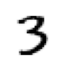

In [98]:
show_image(threes_tensors[1]);

In [99]:
type(zeros_tensors)

list

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. To do this we first combine all the images in this list into a single three-dimensional tensor. The most common way to describe such a tensor is to call it a *rank-3 tensor*. We often need to stack up individual tensors in a collection into a single tensor. Unsurprisingly, PyTorch comes with a function called `stack` that we can use for this purpose.

Some operations in PyTorch, such as taking a mean, require us to *cast* our integer types to float types. Since we'll be needing this later, we'll also cast our stacked tensor to `float` now. Casting in PyTorch is as simple as typing the name of the type you wish to cast to, and treating it as a method.

Generally when images are floats, the pixel values are expected to be between 0 and 1, so we will also divide by 255 here:

In [100]:
stacked_sevens = torch.stack(sevens_tensors).float()/255
stacked_threes = torch.stack(threes_tensors).float()/255
stacked_ones = torch.stack(ones_tensors).float()/255
stacked_twos = torch.stack(twos_tensors).float()/255
stacked_fours = torch.stack(fours_tensors).float()/255
stacked_fives = torch.stack(fives_tensors).float()/255
stacked_sixes = torch.stack(sixes_tensors).float()/255
stacked_eights = torch.stack(eights_tensors).float()/255
stacked_nines = torch.stack(nines_tensors).float()/255
stacked_zeros = torch.stack(zeros_tensors).float()/255

stacked_threes.shape

torch.Size([6131, 28, 28])

In [101]:
type(stacked_threes)

torch.Tensor

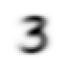

In [102]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

According to this dataset, this is the ideal number 3! (You may not like it, but this is what peak number 3 performance looks like.) You can see how it's very dark where all the images agree it should be dark, but it becomes wispy and blurry where the images disagree. 

Let's do the same thing for the 7s, but put all the steps together at once to save some time:

In [103]:
stacked_sevens.mean()

tensor(0.1145)

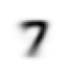

In [104]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

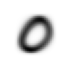

In [106]:
mean0 = stacked_zeros.mean(0)
show_image(mean0);

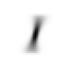

In [107]:
mean1 = stacked_ones.mean(0)
show_image(mean1);

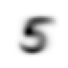

In [111]:
mean5 = stacked_fives.mean(0)
show_image(mean5);

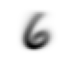

In [112]:
mean6 = stacked_sixes.mean(0)
show_image(mean6);

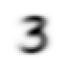

In [109]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

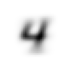

In [110]:
mean4 = stacked_fours.mean(0)
show_image(mean4);

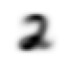

In [108]:
mean2 = stacked_twos.mean(0)
show_image(mean2);

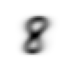

In [113]:
mean8= stacked_eights.mean(0)
show_image(mean8);

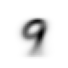

In [114]:
mean9 = stacked_nines.mean(0)
show_image(mean9);

Let's now pick an arbitrary 3 and measure its *distance* from our "ideal digits."

> stop: Stop and Think!: How would you calculate how similar a particular image is to each of our ideal digits? Remember to step away from this book and jot down some ideas before you move on! Research shows that recall and understanding improves dramatically when you are engaged with the learning process by solving problems, experimenting, and trying new ideas yourself

Here's a sample 3:

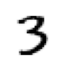

In [105]:
a_3 = stacked_threes[1]
show_image(a_3);

How can we determine its distance from our ideal 3? We can't just add up the differences between the pixels of this image and the ideal digit. Some differences will be positive while others will be negative, and these differences will cancel out, resulting in a situation where an image that is too dark in some places and too light in others might be shown as having zero total differences from the ideal. That would be misleading!

To avoid this, there are two main ways data scientists measure distance in this context:

- Take the mean of the *absolute value* of differences (absolute value is the function that replaces negative values with positive values). This is called the *mean absolute difference* or *L1 norm*
- Take the mean of the *square* of differences (which makes everything positive) and then take the *square root* (which undoes the squaring). This is called the *root mean squared error* (RMSE) or *L2 norm*.

> important: It's Okay to Have Forgotten Your Math: In this book we generally assume that you have completed high school math, and remember at least some of it... But everybody forgets some things! It all depends on what you happen to have had reason to practice in the meantime. Perhaps you have forgotten what a _square root_ is, or exactly how they work. No problem! Any time you come across a maths concept that is not explained fully in this book, don't just keep moving on; instead, stop and look it up. Make sure you understand the basic idea, how it works, and why we might be using it. One of the best places to refresh your understanding is Khan Academy. For instance, Khan Academy has a great [introduction to square roots](https://www.khanacademy.org/math/algebra/x2f8bb11595b61c86:rational-exponents-radicals/x2f8bb11595b61c86:radicals/v/understanding-square-roots).

Let's try both of these now:

In [38]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [117]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

PyTorch already provides both of these as *loss functions*. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai):

In [118]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

Here `mse` stands for *mean squared error*, and `l1` refers to the standard mathematical jargon for *mean absolute value* (in math it's called the *L1 norm*).

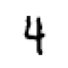

In [119]:
a_4 = stacked_fours[1]
show_image(a_4);

In [120]:
dist_4_abs = (a_4 - mean4).abs().mean()
dist_4_sqr = ((a_4 - mean4)**2).mean().sqrt()
dist_4_abs,dist_4_sqr

(tensor(0.1126), tensor(0.2138))

In [121]:
dist_4_abs = (a_4 - mean7).abs().mean()
dist_4_sqr = ((a_4 - mean7)**2).mean().sqrt()
dist_4_abs,dist_4_sqr

(tensor(0.1246), tensor(0.2471))

In both cases, the distance between our 3 and the "ideal" 3 is less than the distance to the ideal 7. So our simple model will give the right prediction in this case.

PyTorch already provides both of these as *loss functions*. You'll find these inside `torch.nn.functional`, which the PyTorch team recommends importing as `F` (and is available by default under that name in fastai):

In [122]:
F.l1_loss(a_4.float(),mean4), F.mse_loss(a_4,mean4).sqrt()

(tensor(0.1126), tensor(0.2138))

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?
1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
1. Explain how the "pixel similarity" approach to classifying digits works.
1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.
1. What is a "rank-3 tensor"?
1. What is the difference between tensor rank and shape? How do you get the rank from the shape?
1. What are RMSE and L1 norm?
1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.
1. What is broadcasting?
1. Are metrics generally calculated using the training set, or the validation set? Why?
1. What is SGD?
1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?
1. How do we initialize the weights in a model?
1. What is "loss"?
1. Why can't we always use a high learning rate?
1. What is a "gradient"?
1. Do you need to know how to calculate gradients yourself?
1. Why can't we use accuracy as a loss function?
1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.